In [1]:
from google.colab import drive
import os
import shutil

# Monter Google Drive
drive.mount('/content/drive')

# Chemin du fichier ZIP dans Google Drive
zip_path_drive = "/content/drive/MyDrive/datasets/plantvillage_segmented.zip"

# Chemin du fichier ZIP dans l'arborescence Colab
zip_path_colab = "/content/plantvillage_segmented.zip"

# Chemin du répertoire de destination pour la décompression
extract_path = "/content/plantvillage_segmented"

# Supprimer le répertoire s'il existe
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
    print(f"Répertoire {extract_path} supprimé")

# Créer le répertoire de destination
os.makedirs(extract_path)

# Copier le fichier ZIP de Google Drive vers Colab
shutil.copy(zip_path_drive, zip_path_colab)
print(f"Fichier {zip_path_drive} copié vers {zip_path_colab}")

# Décompresser le fichier ZIP en conservant l'arborescence
os.system(f'unzip {zip_path_colab} -d {extract_path}')

print(f"Fichier {zip_path_colab} décompressé dans {extract_path}")


Mounted at /content/drive
Fichier /content/drive/MyDrive/datasets/plantvillage_segmented.zip copié vers /content/plantvillage_segmented.zip
Fichier /content/plantvillage_segmented.zip décompressé dans /content/plantvillage_segmented


In [2]:
from google.colab import drive
import os
import shutil
import datetime

# Monter Google Drive
drive.mount('/content/drive')

# Fonction pour créer un nom de modèle unique
def create_model_name(model_type, params):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model_name = f"{model_type}_{params['image_size']}x{params['image_size']}_B{params['batch_size']}_LR{params['learning_rate']}_E{params['epochs']}_{timestamp}"
    return model_name

# Configurations
base_dir = '/content/drive/My Drive/ColabResults/'
image_size = 224
batch_size = 32
epochs = 20
learning_rate = 0.0001
model_type = "CNNMobilNetv1Complet_Model"
params = {
    'image_size': image_size,
    'batch_size': batch_size,
    'epochs': epochs,
    'learning_rate': learning_rate,
}

# Créer le nom du modèle et le répertoire unique
model_name = create_model_name(model_type, params)
model_dir = os.path.join(base_dir, model_name)
os.makedirs(model_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau

# Fixer les graines pour la reproductibilité
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Configurations
image_size = 224
batch_size = 32
validation_split = 0.2

# Chemin vers les données
base_dir_data = "/content/plantvillage_segmented/content/plantvillage-dataset/plantvillage dataset/segmented"

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Création des datasets avec validation split
train_dataset = image_dataset_from_directory(
    base_dir_data,
    validation_split=validation_split,
    subset='training',
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    base_dir_data,
    validation_split=validation_split,
    subset='validation',
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

# Obtenir les noms des classes
class_names = train_dataset.class_names

# Normalisation des datasets
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))

# Calcul des steps_per_epoch et validation_steps
num_train_batches = tf.data.experimental.cardinality(train_dataset).numpy()
num_val_batches = tf.data.experimental.cardinality(validation_dataset).numpy()
steps_per_epoch = num_train_batches
validation_steps = num_val_batches

print(f"Nombre total de batches d'entraînement: {num_train_batches}")
print(f"Nombre total de batches de validation: {num_val_batches}")

# Appliquer .repeat() après avoir obtenu les noms des classes
train_dataset = train_dataset.repeat()
validation_dataset = validation_dataset.repeat()



Found 54281 files belonging to 38 classes.
Using 43425 files for training.
Found 54281 files belonging to 38 classes.
Using 10856 files for validation.
Nombre total de batches d'entraînement: 1358
Nombre total de batches de validation: 340


In [4]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet

inputs = Input(shape=(224, 224, 3))
base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=inputs)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])





<ipython-input-4-c7c32630c044>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=inputs)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:

# Entraîner le modèle
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)




Epoch 1/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 191s 113ms/step - accuracy: 0.7508 - loss: 0.9675 - val_accuracy: 0.9785 - val_loss: 0.0656 - learning_rate: 1.0000e-04
Epoch 2/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 136s 100ms/step - accuracy: 0.9693 - loss: 0.0976 - val_accuracy: 0.9882 - val_loss: 0.0379 - learning_rate: 1.0000e-04
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 136s 101ms/step - accuracy: 0.9821 - loss: 0.0553 - val_accuracy: 0.9854 - val_loss: 0.0458 - learning_rate: 1.0000e-04
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 136s 100ms/step - accuracy: 0.9882 - loss: 0.0366 - val_accuracy: 0.9901 - val_loss: 0.0338 - learning_rate: 1.0000e-04
Epoch 5/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 137s 101ms/step - accuracy: 0.9894 - loss: 0.0320 - val_accuracy: 0.9859 - val_loss: 0.0497 - learning_rate: 1.0000e-04
Epoch 6/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 138s 101ms/step - accuracy: 0.9911 - loss: 0.0270 - val_accuracy: 0.9878 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 7/20
1358/1358 ━━━━━━━

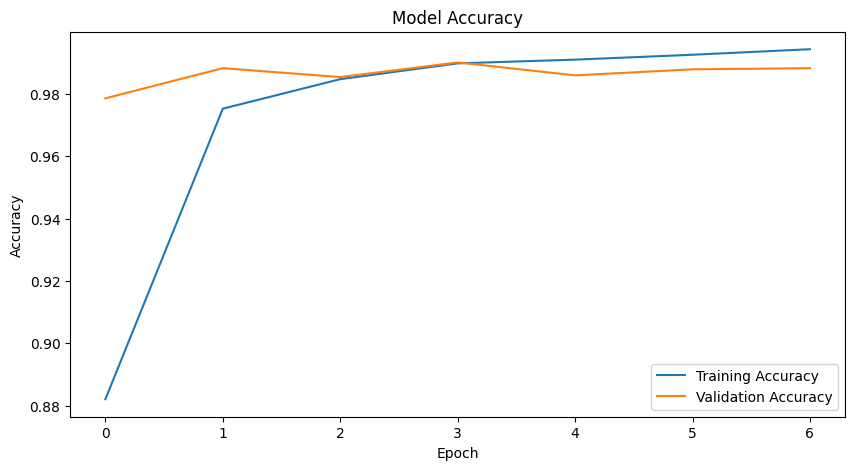

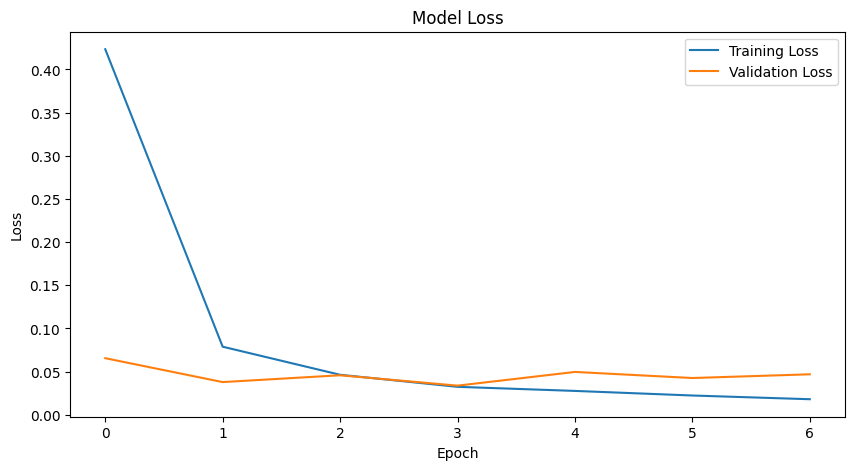

In [6]:
import matplotlib.pyplot as plt

# Visualisation des résultats
def plot_metrics(history, model_dir):
    # Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(model_dir, 'model_accuracy.png'))  # Sauvegarder le graphe d'accuracy
    plt.show()

    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(model_dir, 'model_loss.png'))  # Sauvegarder le graphe de perte
    plt.show()

plot_metrics(history, model_dir)



In [7]:
from sklearn.metrics import classification_report

# Prédictions sur les données de validation
val_dataset_no_repeat = validation_dataset.take(validation_steps)  # Assurez-vous de ne pas répéter le dataset pour l'évaluation
y_true = []
y_pred = []

for images, labels in val_dataset_no_repeat:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Obtenir les classes uniques dans y_true et y_pred
unique_classes = sorted(set(y_true + y_pred))
adjusted_class_names = [class_names[i] for i in unique_classes]

# Génération du rapport de classification
report = classification_report(y_true, y_pred, labels=unique_classes, target_names=adjusted_class_names, zero_division=0)
print(report)

# Sauvegarde du rapport dans un fichier texte
with open(os.path.join(model_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

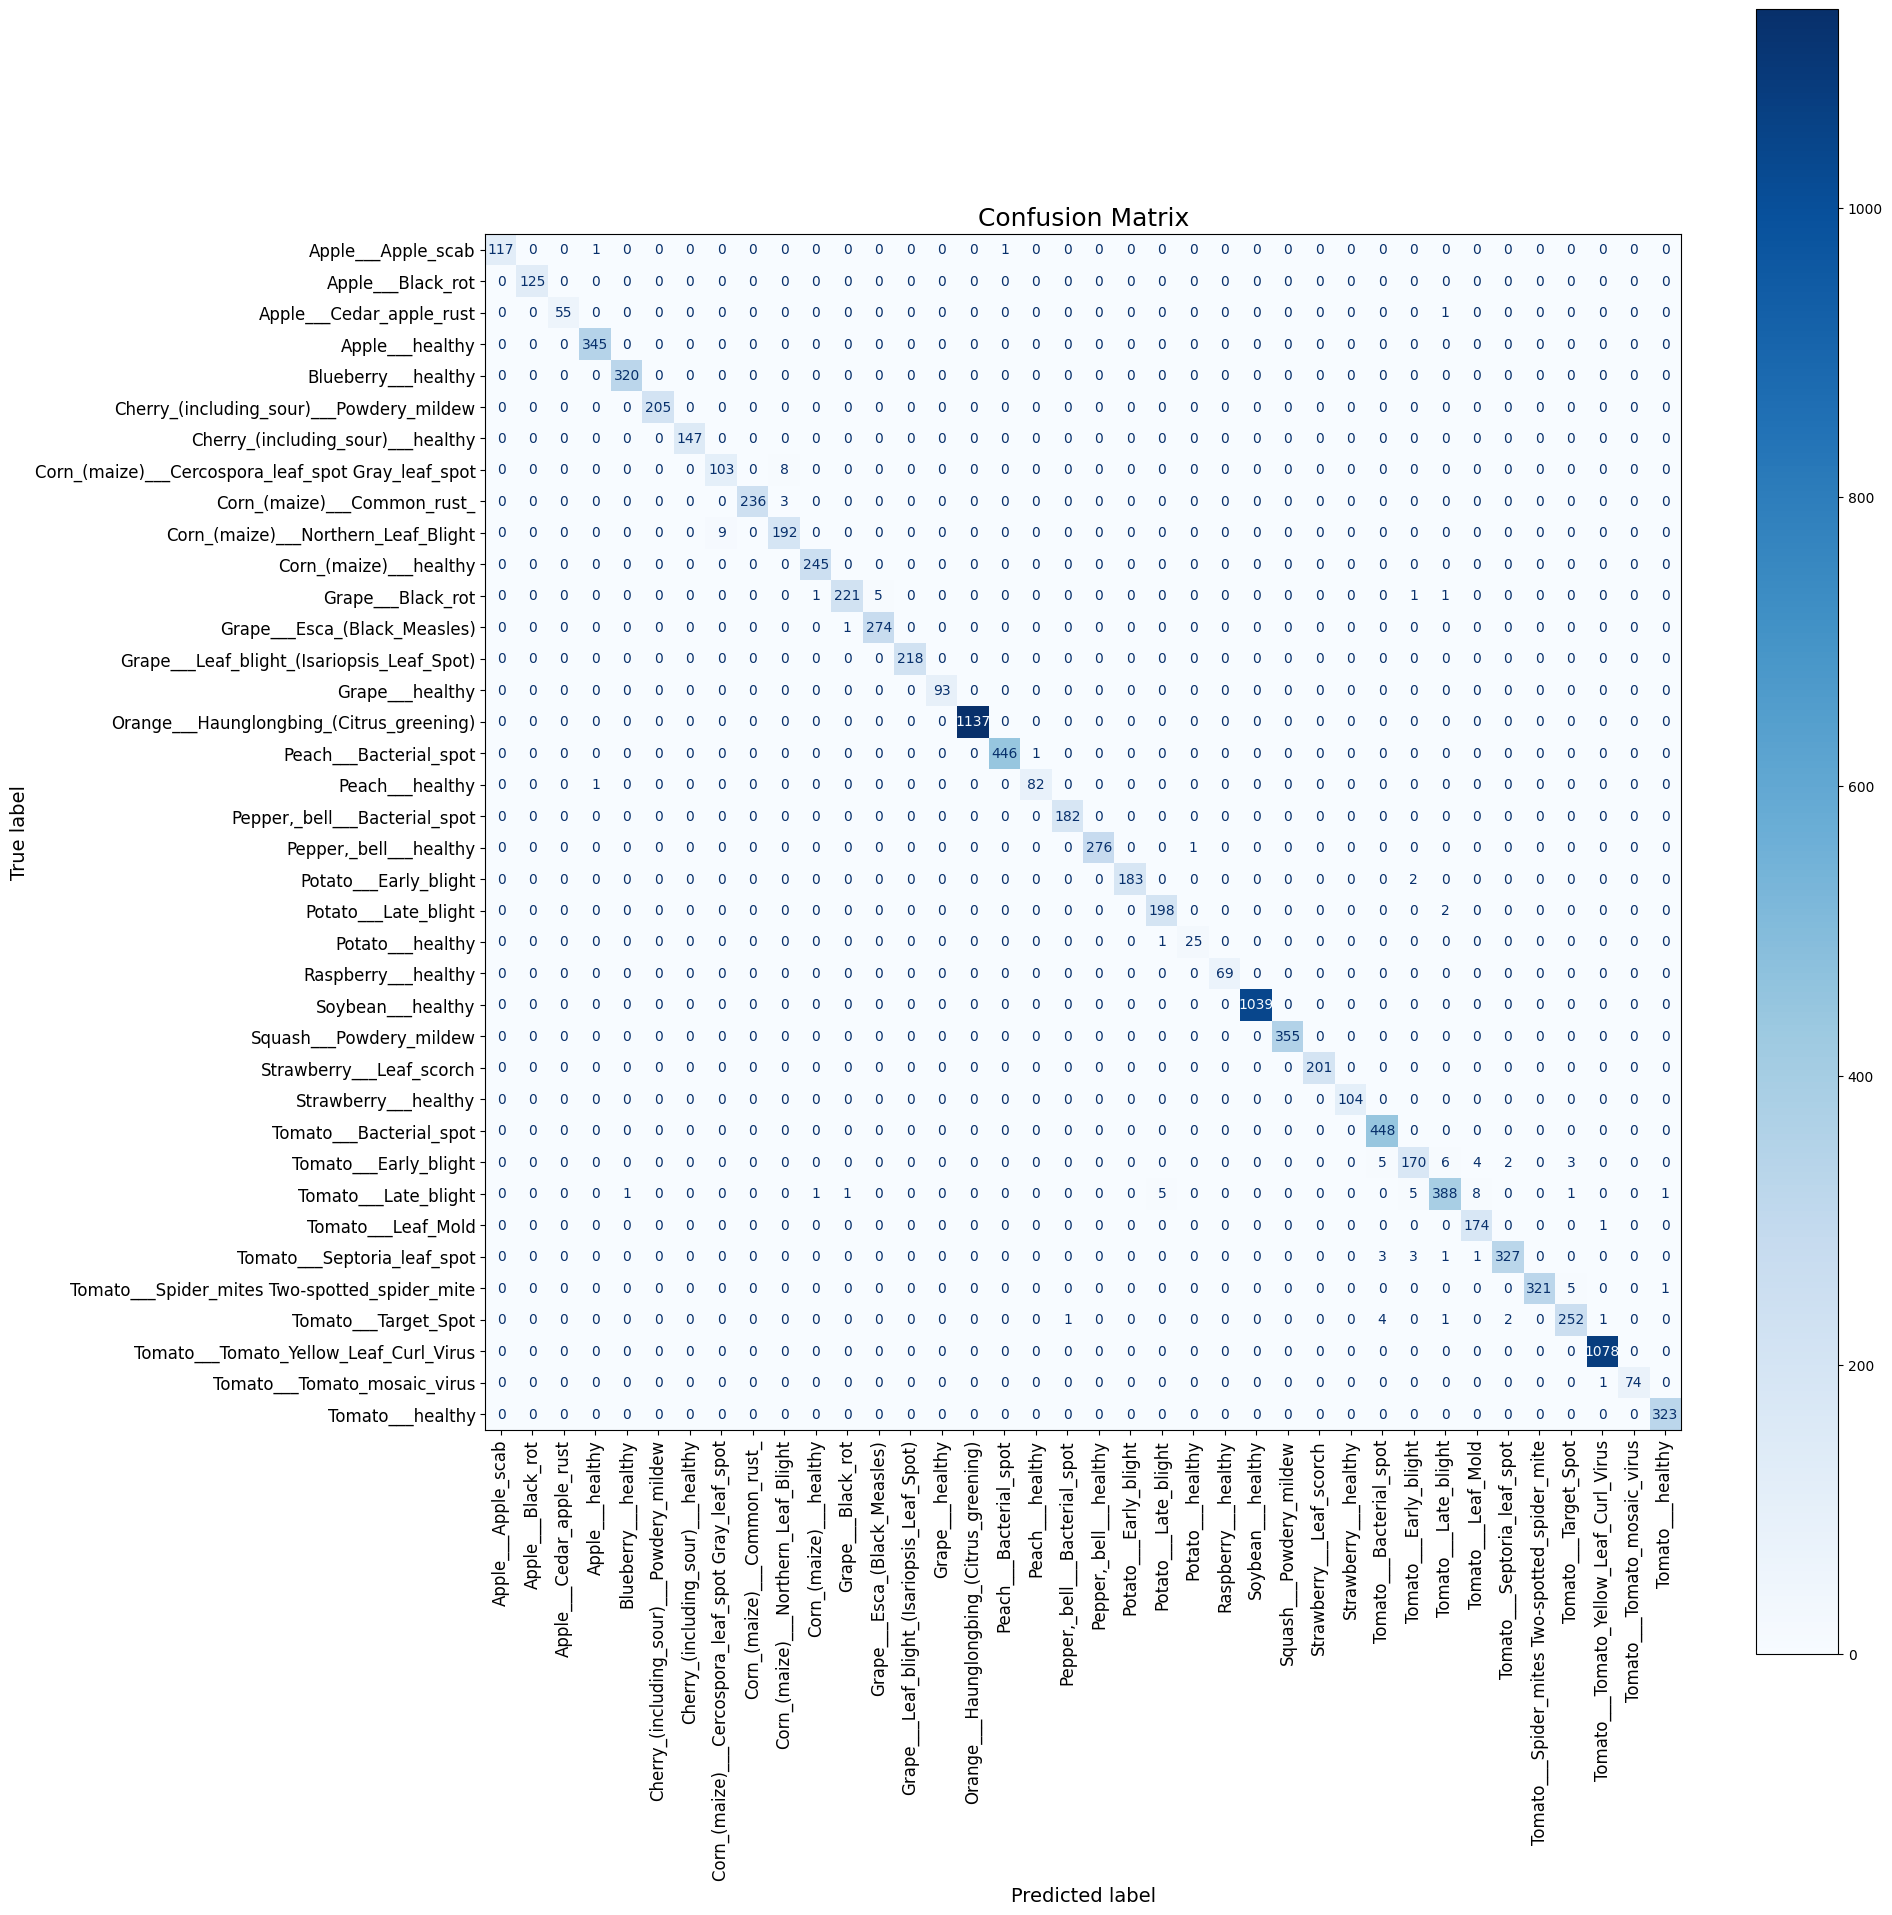

Matrice de confusion sauvegardée dans /content/drive/My Drive/ColabResults/CNNMobilNetv1Complet_Model_224x224_B32_LR0.0001_E20_20240926-061957/confusion_matrix.csv
Matrice de confusion sauvegardée au format JSON dans /content/drive/My Drive/ColabResults/CNNMobilNetv1Complet_Model_224x224_B32_LR0.0001_E20_20240926-061957/confusion_matrix.json


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import json
import os

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# Vérification du nombre de labels et de classes
assert len(unique_classes) == len(adjusted_class_names), "Le nombre de labels ne correspond pas au nombre de classes uniques."

# Augmentation de la taille de la figure
plt.figure(figsize=(20, 20))

# Création de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adjusted_class_names)

# Ajout des annotations
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, values_format='.0f', ax=plt.gca())

# Ajout des titres et labels avec taille de police ajustée
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Sauvegarder la matrice de confusion améliorée en image
plt.savefig(os.path.join(model_dir, 'confusion_matrix_improved.png'))
plt.show()

# Sauvegarde de la matrice de confusion au format CSV
cm_df = pd.DataFrame(cm, index=adjusted_class_names, columns=adjusted_class_names)
csv_path = os.path.join(model_dir, 'confusion_matrix.csv')
cm_df.to_csv(csv_path)
print(f"Matrice de confusion sauvegardée dans {csv_path}")

# Sauvegarde de la matrice de confusion au format JSON
json_path = os.path.join(model_dir, 'confusion_matrix.json')
cm_json = cm_df.to_dict()  # Convertir la matrice en dictionnaire

# Écriture dans un fichier JSON
with open(json_path, 'w') as json_file:
    json.dump(cm_json, json_file, indent=4)
print(f"Matrice de confusion sauvegardée au format JSON dans {json_path}")





In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Répertoire où les images mal classifiées seront sauvegardées
incorrect_images_dir = os.path.join(model_dir, 'incorrect_images')
os.makedirs(incorrect_images_dir, exist_ok=True)

# Fonction pour sauvegarder uniquement les images mal classifiées sans Grad-CAM
def save_incorrect_images(dataset, predictions, labels, indices, dir_path, class_names):
    index = 0  # Index pour le nom des fichiers
    for batch_idx, (images, true_labels) in enumerate(dataset):
        batch_predictions = np.argmax(model.predict(images), axis=-1)
        for img_idx, (image, true_label, pred_label) in enumerate(zip(images, true_labels, batch_predictions)):
            if index >= len(indices):
                return  # Stop if we have saved all incorrect images

            # Convertir l'image de Tensor à NumPy array et denormaliser
            img_array = image.numpy().astype('float32') * 255
            img_array = img_array.astype('uint8')

            # Sauvegarder uniquement si l'étiquette prédite est incorrecte
            if true_label != pred_label:
                plt.figure()
                plt.imshow(img_array)
                plt.axis('off')  # Retirer le titre

                # Accéder correctement aux étiquettes de classes
                true_class_name = class_names[int(true_label.numpy())]  # Assurer un accès correct
                pred_class_name = class_names[int(pred_label)]  # Assurer un accès correct
                file_path_original = os.path.join(dir_path, f'{true_class_name}_{pred_class_name}_{index}.jpg')
                plt.savefig(file_path_original, format='jpg', bbox_inches='tight')
                plt.close()

                index += 1

# Comparaison des prédictions avec les vraies étiquettes
incorrect_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]


# Appel de la fonction pour sauvegarder les images mal classifiées sans Grad-CAM
save_incorrect_images(val_dataset_no_repeat, y_pred, y_true, incorrect_indices, incorrect_images_dir, class_names)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [10]:
# Copier les fichiers vers Google Drive
model.save('CNN1.keras')
shutil.copy('CNN1.keras', os.path.join(model_dir, 'CNN1.keras'))


'/content/drive/My Drive/ColabResults/CNNMobilNetv1Complet_Model_224x224_B32_LR0.0001_E20_20240926-061957/CNN1.keras'